# Next Item

In [1]:
import warnings
warnings.simplefilter('ignore')

import gc
import re
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
df_sess = pd.read_csv('data/sessions_train.csv')
df_sess

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE
...,...,...,...
3606244,['B086CYFSKW' 'B0874F9859' 'B086CYFSKW'],B07B5TYD76,IT
3606245,['B09NRZKZ7V' 'B08WJTPV93'],B08L1P4C3D,IT
3606246,['B085JFX7MP' 'B085JGHW8R'],B01MPWVD44,IT
3606247,['B00B0UING2' 'B00B0UING2'],B00D3HYEZ4,IT


In [3]:
df_test = pd.read_csv('data/sessions_test_task1.csv')
df_test

,prev_items,locale
0,['B08V12CT4C' 'B08V1KXBQD' 'B01BVG1XJS' 'B09VC...,DE
1,['B00R9R5ND6' 'B00R9RZ9ZS' 'B00R9RZ9ZS'],DE
2,['B07YSRXJD3' 'B07G7Q5N6G' 'B08C9Q7QVK' 'B07G7...,DE
3,['B08KQBYV43' '3955350843' '3955350843' '39553...,DE
4,['B09FPTCWMC' 'B09FPTQP68' 'B08HMRY8NG' 'B08TB...,DE
...,...,...
316966,['B077SZ2C3Y' 'B0B14M3VZX'],UK
316967,['B08KFHDPY9' 'B0851KTSRZ' 'B08KFHDPY9' 'B0851...,UK
316968,['B07PY1N81F' 'B07Q1Z8SQN' 'B07PY1N81F' 'B07Q1...,UK
316969,['B01MCQMORK' 'B09JYZ325W'],UK


In [4]:
def str2list(x):
    x = x.replace('[', '').replace(']', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    l = [i for i in x.split() if i]
    return l

In [5]:
next_item_dict = defaultdict(list)

for _, row in tqdm(df_sess.iterrows(), total=len(df_sess)):
    prev_items = str2list(row['prev_items'])
    next_item = row['next_item']
    prev_items_length = len(prev_items)
    if prev_items_length <= 1:
        next_item_dict[prev_items[0]].append(next_item)
    else:
        for i, item in enumerate(prev_items[:-1]):
            next_item_dict[item].append(prev_items[i+1])
        next_item_dict[prev_items[-1]].append(next_item)

  0%|          | 0/3606249 [00:00<?, ?it/s]

In [6]:
for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    prev_items = str2list(row['prev_items'])
    prev_items_length = len(prev_items)
    if prev_items_length <= 1:
        continue
    else:
        for i, item in enumerate(prev_items[:-1]):
            next_item_dict[item].append(prev_items[i+1])

  0%|          | 0/316971 [00:00<?, ?it/s]

In [7]:
next_item_map = {}

for item in tqdm(next_item_dict):
    counter = Counter(next_item_dict[item])
    next_item_map[item] = [i[0] for i in counter.most_common(100)]

  0%|          | 0/1334818 [00:00<?, ?it/s]

In [8]:
k = []
v = []

for item in next_item_dict:
    k.append(item)
    v.append(next_item_dict[item])
    
df_next = pd.DataFrame({'item': k, 'next_item': v})
df_next = df_next.explode('next_item').reset_index(drop=True)
df_next

,item,next_item
0,B09W9FND7K,B09JSPLN1M
1,B09W9FND7K,B09JSPLN1M
2,B09W9FND7K,B09JSPLN1M
3,B09W9FND7K,B09JSPLN1M
4,B09W9FND7K,B078WW2WN5
...,...,...
16340339,B0BFPLN8FQ,B0BF5GT13X
16340340,B09737CD6H,B08DJ9SQFY
16340341,B084GZ3QZ7,B00CBAW8SE
16340342,B081TXFKS5,B004RN5I6W


In [9]:
top200 = df_next['next_item'].value_counts().index.tolist()[:200]

In [10]:
df_test['last_item'] = df_test['prev_items'].apply(lambda x: str2list(x)[-1])
df_test['next_item_prediction'] = df_test['last_item'].map(next_item_map)
df_test

,prev_items,locale,last_item,next_item_prediction
0,['B08V12CT4C' 'B08V1KXBQD' 'B01BVG1XJS' 'B09VC...,DE,B099NQFMG7,"[B099NS1XPG, B08496TCCQ, B01BVG1XJS, B099NR3X6..."
1,['B00R9R5ND6' 'B00R9RZ9ZS' 'B00R9RZ9ZS'],DE,B00R9RZ9ZS,"[B004ZXMV4Q, B00R9R5ND6, B095TQTZXY, B086J6RTT..."
2,['B07YSRXJD3' 'B07G7Q5N6G' 'B08C9Q7QVK' 'B07G7...,DE,B07G7Q5N6G,"[B08C9Q7QVK, B07G7Q5N6G, B07YSRXJD3, B0B5QNFWJ..."
3,['B08KQBYV43' '3955350843' '3955350843' '39553...,DE,3955350843,"[395535086X, 3955350843, B0829LZFT1, 377247695..."
4,['B09FPTCWMC' 'B09FPTQP68' 'B08HMRY8NG' 'B08TB...,DE,B09J945WQR,"[B09J8V18FL, B09J8T6TTH, B09J8SKX9G, B09J8V9RQ..."
...,...,...,...,...
316966,['B077SZ2C3Y' 'B0B14M3VZX'],UK,B0B14M3VZX,"[B08X9L5RGD, B07V5FL8G6, B09Y4HKGKT, B09MW64JGM]"
316967,['B08KFHDPY9' 'B0851KTSRZ' 'B08KFHDPY9' 'B0851...,UK,B081YDH55K,"[B0989BHLSY, B09CPNS7XV, B09895QPQF, B09CPP92Q..."
316968,['B07PY1N81F' 'B07Q1Z8SQN' 'B07PY1N81F' 'B07Q1...,UK,B09HL11V5B,"[B09HKZBNZH, B09HZSRJWW, B09HL141QC, B09HX9VGW..."
316969,['B01MCQMORK' 'B09JYZ325W'],UK,B09JYZ325W,"[B07TR5LQSL, B08FB464L7, B09JYZ325W, B08JG8TSC..."


In [11]:
# next items preds
df_test_de = df_test[df_test["locale"] == "DE"]
df_test_uk = df_test[df_test["locale"] == "UK"]
df_test_jp = df_test[df_test["locale"] == "JP"]

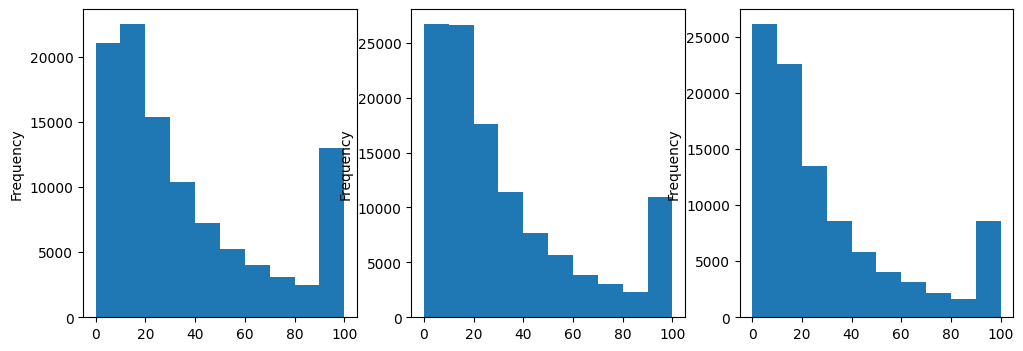

In [12]:
def get_length(l):
    if type(l) == list:
        return len(l)
    else:
        return 0

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

df_test_de["next_item_prediction"].apply(get_length).plot(kind="hist", ax =axs[0])
df_test_uk["next_item_prediction"].apply(get_length).plot(kind="hist", ax =axs[1])
df_test_jp["next_item_prediction"].apply(get_length).plot(kind="hist", ax =axs[2])

plt.show()

# Fill up with FAISS

In [13]:
# faiss preds
preds_de_path = "/pfs/work7/workspace/scratch/ma_ndoering-data_mining_2/pred_sessions_test_task1_de.csv"
preds_uk_path = "/pfs/work7/workspace/scratch/ma_ndoering-data_mining_2/pred_sessions_test_task1_uk.csv"
preds_jp_path = "/pfs/work7/workspace/scratch/ma_ndoering-data_mining_2/pred_sessions_test_task1_jp.csv"

preds_de = pd.read_csv(preds_de_path, index_col=[0])
preds_uk = pd.read_csv(preds_uk_path, index_col=[0])
preds_jp = pd.read_csv(preds_jp_path, index_col=[0])

# strings to lists
preds_de['next_item'] = preds_de['next_item'].str.strip("[']").str.split("', '")
preds_uk['next_item'] = preds_uk['next_item'].str.strip("[']").str.split("', '")
preds_jp['next_item'] = preds_jp['next_item'].str.strip("[']").str.split("', '")

# read train sessions
train_sessions_path = "./data/sessions_train.csv"
train_sessions = pd.read_csv(train_sessions_path)
train_sessions['prev_items'] = train_sessions['prev_items'].str.strip("[']").str.replace("\n", "").str.split("' '")

# 100 most common items per locale
most_common_de = list(train_sessions[train_sessions["locale"] == "DE"]["next_item"].value_counts()[:100].index)
most_common_uk = list(train_sessions[train_sessions["locale"] == "DE"]["next_item"].value_counts()[:100].index)
most_common_jp = list(train_sessions[train_sessions["locale"] == "DE"]["next_item"].value_counts()[:100].index)

# fill up next_item lists that are shorter than 100 items with most common items
def fill_up(next_items, locale):
    n_items_missing = 100 - len(next_items)
    if n_items_missing > 0:
        if locale == "DE":
            return next_items + most_common_de[:n_items_missing]
        if locale == "UK":
            return next_items + most_common_uk[:n_items_missing]
        if locale == "JP":
            return next_items + most_common_jp[:n_items_missing]
    else:
        return next_items
    
preds_de["next_item"] = preds_de["next_item"].apply(lambda l: fill_up(l, "DE"))
preds_uk["next_item"] = preds_uk["next_item"].apply(lambda l: fill_up(l, "UK"))
preds_jp["next_item"] = preds_jp["next_item"].apply(lambda l: fill_up(l, "JP"))

In [14]:
# add column with "next item" model predictions
preds_de = preds_de.join(df_test_de["next_item_prediction"].to_frame().rename(columns={"next_item_prediction": "ni_preds"}))
preds_jp = preds_jp.join(df_test_jp["next_item_prediction"].to_frame().rename(columns={"next_item_prediction": "ni_preds"}))
preds_uk = preds_uk.join(df_test_uk["next_item_prediction"].to_frame().rename(columns={"next_item_prediction": "ni_preds"}))

display(preds_de)
display(preds_jp)
display(preds_uk)

,prev_items,locale,next_item,ni_preds
0,"['B08V12CT4C', 'B08V1KXBQD', 'B01BVG1XJS', 'B0...",DE,"[B08V1KXBQD, B07TV22X9M, B08V12CT4C, B099NS1XP...","[B099NS1XPG, B08496TCCQ, B01BVG1XJS, B099NR3X6..."
1,"['B00R9R5ND6', 'B00R9RZ9ZS', 'B00R9RZ9ZS']",DE,"[B00R9RZ9ZS, B00R9R5ND6, B095TL42FL, 377246997...","[B004ZXMV4Q, B00R9R5ND6, B095TQTZXY, B086J6RTT..."
2,"['B07YSRXJD3', 'B07G7Q5N6G', 'B08C9Q7QVK', 'B0...",DE,"[B07G7Q5N6G, B08C9Q7QVK, B099277D7Q, B09XTMPM8...","[B08C9Q7QVK, B07G7Q5N6G, B07YSRXJD3, B0B5QNFWJ..."
3,"['B08KQBYV43', '3955350843', '3955350843', '39...",DE,"[3741524131, 3955350878, 395535086X, B0041VW2D...","[395535086X, 3955350843, B0829LZFT1, 377247695..."
4,"['B09FPTCWMC', 'B09FPTQP68', 'B08HMRY8NG', 'B0...",DE,"[B09J8V18FL, B09J8VPTTW, B09J8TTZ68, B09J8SKX9...","[B09J8V18FL, B09J8T6TTH, B09J8SKX9G, B09J8V9RQ..."
...,...,...,...,...
104563,"['B014I8SSD0', 'B07YTX31J8', 'B07TVG9964', 'B0...",DE,"[B00B4CVV60, B004BHZHIS, B004XISZ8E, B00SWYTH3...","[B014I8SIJY, B014I8SSD0, B07D6MRT2K, B014I8SX4..."
104564,"['B003M0NURK', 'B09VPJ4394', 'B07TVH9NHP']",DE,"[B08CMPSCMQ, B08CMX8WZ6, B07TVH9NHP, B09VPJ439...","[B09VPJ4394, B096KJWMQQ, B0B4W8MMDB, B09VG7CYQ..."
104565,"['B07B38Z3S7', 'B079HF6FSP', 'B079HF6FSP', 'B0...",DE,"[B079MBWZS9, B079HF6FSP, B07B33GMCF, B079H8G39...","[B07B38Z3S7, B079MD3F7Q, B00E6HAOAY, B079H6L89..."
104566,"['B00HFDYJGQ', 'B018G6YYDI', 'B00HFDYJGQ']",DE,"[B08JH6P9JF, B08JH72VJG, B00HFDYYRU, B00HFDYJG...","[B00HFDYJGQ, B08JH72VJG, B08JH6P9JF, B018G6YWQ..."


,prev_items,locale,next_item,ni_preds
104568,"['B09NZHMKXW', 'B0823M5W31', 'B017GSMOJS', 'B0...",JP,"[B08NZN9WC1, B09S25SZ1Q, B06Y4F4NDS, B0BBW7QVH...","[B00VE35ZVQ, B00VE34L7A, B09DX2BWGY]"
104569,"['B08S31PW4G', 'B09TKN5SGL']",JP,"[B09BHP5PP1, B07F3WG12T, B09CG7D7LN, B08FB62GK...","[B0B8RZ1CSH, B09R177Y3K]"
104570,"['B0BHWBZ4ZJ', 'B0BHWBZ4ZJ', 'B09MQCDRZ1', 'B0...",JP,"[B09V7RBRWN, B000J3VKLQ, B09CD5BQ7Y, B0B7NHB4Q...","[B0BHWBZ4ZJ, B0BFB18WWY, B09364MS3M, B019GNUT0..."
104571,"['B07VHJZQYB', 'B07Y1P1B5T']",JP,"[B087CQM9BT, B089SWFFFV, B07VCLCJT3, B07K9LGGQ...","[B07QCL7FHC, B07Y1P1B5T, B07QJWZWXL, B07VHJZQY..."
104572,"['B09JK112HQ', 'B07GCTJ7JX', 'B0BKK2NRPJ', 'B0...",JP,"[B09FSNXWKP, B0926NWR4L, B09QXDVQ1V, B088ZW7GD...","[B07PK63NHW, B07GCTJ7JX, B08D5ZB5YM, B08FC3YQ2..."
...,...,...,...,...
201030,"['B06WVR45WV', 'B00SMEQW6C', 'B00SMEQW3U']",JP,"[B005DY18Y0, B006RI3QN2, B07JZLWPQQ, B08QR8X8D...","[B00SMEQW6C, B06WVPGT4B, B06VY2PZWL, B086V1VZB..."
201031,"['B07QSHYZDR', 'B07QSHYZDR', 'B00AMUOOPK', 'B0...",JP,"[B0BBTP4S6N, B0B5KP97T5, B09SGBD4JF, B00FGI2QV...","[B0044IF40A, B07LB476VT, B09GJSHDDF, B07V8SPMX..."
201032,"['B0146F7BBU', 'B06XCKFSTS', 'B007TFQ2QU']",JP,"[B00O9N1BEI, B0B48XHCRV, B07JG3JMCC, B005IXH6D...","[B00ZOYM208, B007TFQ2O2, B007TFQ2QU, B01B8R6PF..."
201033,"['B09SHMC6KN', 'B09SHMC6KN', 'B07PYRX4D6', 'B0...",JP,"[B07Q614Z3C, B07XGZWDZ4, B09PBD5H8X, B0B3X3FDH...","[B09JDGYSQW, B09JFLJTZG, B0B8CV52YL, B09JDHKR6..."


,prev_items,locale,next_item,ni_preds
201035,"['B007MO0FIO', 'B09QXPN2TL', 'B005PA3I8G', 'B0...",UK,"[B091TLGK2T, B0BFX4PPYM, B08WPCZ8KR, B09J95XLG...","[B0030G0FG0, B09QXPN2TL, B007FT5C5W, B007MO0FI..."
201036,"['B082P6M3HC', 'B082BHJ9G8', 'B0797QCXS6', 'B0...",UK,"[B0791BS4NL, B09SH64F6S, B07S7CZZ7L, B09WZ4FJ3...","[B082DN72G3, B082P6M3HC, B082DPBHWW, B082DNYP7..."
201037,"['B0894HWG1H', 'B07S79G11S', 'B092VCHVS7', 'B0...",UK,"[B0B7RW8HYV, B07TS1NXSH, B07MMWKWH1, B08HFJJTJ...","[B078H3DHHL, B0B8SGTCKJ, B09P26QRFM, B01M30N2R..."
201038,"['B00FLTE8OE', 'B07CRNCKMR', 'B0784T65RK']",UK,"[B0B717ZVD5, B006L4DLW8, B091F4QN7K, B09PF9CPN...","[B00FLTE8OE, B0784T65RK, B092WHDGBD, B092WLHCM..."
201039,"['B0B5XPGRXD', 'B0BHSXQLSX', 'B0BJKJZJNM']",UK,"[3742322508, B095XWVYMN, B001QCELXS, B00629V1D...",[B0BHSXQLSX]
...,...,...,...,...
316966,"['B077SZ2C3Y', 'B0B14M3VZX']",UK,"[B08TVMDJJ7, B088C252ZG, B017XZKLCG, B081RJWHB...","[B08X9L5RGD, B07V5FL8G6, B09Y4HKGKT, B09MW64JGM]"
316967,"['B08KFHDPY9', 'B0851KTSRZ', 'B08KFHDPY9', 'B0...",UK,"[B09HH12F4H, B08GCSTGCN, B09GBLVL8S, B07H4RXYN...","[B0989BHLSY, B09CPNS7XV, B09895QPQF, B09CPP92Q..."
316968,"['B07PY1N81F', 'B07Q1Z8SQN', 'B07PY1N81F', 'B0...",UK,"[B087PFHYSB, B089WCZ5YN, B0B7NTZ4N4, B0B7JBZ9K...","[B09HKZBNZH, B09HZSRJWW, B09HL141QC, B09HX9VGW..."
316969,"['B01MCQMORK', 'B09JYZ325W']",UK,"[B09SDJTL2Z, B093GH3HK6, B07GLMVWTB, B09FF8VS6...","[B07TR5LQSL, B08FB464L7, B09JYZ325W, B08JG8TSC..."


In [16]:
def combine_faiss_and_ni(row):
    ni_preds = row["ni_preds"]
    faiss_preds = row["next_item"]
    if isinstance(ni_preds, list):
        combined = ni_preds + faiss_preds
        u, ind = np.unique(combined, return_index=True)
        combined = u[np.argsort(ind)]
        return combined[:100]
    else:
        return faiss_preds

In [17]:
preds_de["next_item_prediction"] = preds_de.apply(combine_faiss_and_ni, axis=1)
preds_jp["next_item_prediction"] = preds_jp.apply(combine_faiss_and_ni, axis=1)
preds_uk["next_item_prediction"] = preds_uk.apply(combine_faiss_and_ni, axis=1)

In [28]:
# make submission
predictions = pd.concat([
    preds_de[["locale", "next_item"]].rename(columns={"next_item": "next_item_prediction"}),
    preds_jp[["locale", "next_item"]].rename(columns={"next_item": "next_item_prediction"}),
    preds_uk[["locale", "next_item"]].rename(columns={"next_item": "next_item_prediction"}),
])

predictions.head()

,locale,next_item_prediction
0,DE,"[B08V1KXBQD, B07TV22X9M, B08V12CT4C, B099NS1XP..."
1,DE,"[B00R9RZ9ZS, B00R9R5ND6, B095TL42FL, 377246997..."
2,DE,"[B07G7Q5N6G, B08C9Q7QVK, B099277D7Q, B09XTMPM8..."
3,DE,"[3741524131, 3955350878, 395535086X, B0041VW2D..."
4,DE,"[B09J8V18FL, B09J8VPTTW, B09J8TTZ68, B09J8SKX9..."


In [29]:
def check_predictions(predictions, check_products=False):
    """
    These tests need to pass as they will also be applied on the evaluator
    """
    test_locale_names = test_sessions['locale'].unique()
    for locale in test_locale_names:
        sess_test = test_sessions.query(f'locale == "{locale}"')
        preds_locale =  predictions[predictions['locale'] == sess_test['locale'].iloc[0]]
        assert sorted(preds_locale.index.values) == sorted(sess_test.index.values), f"Session ids of {locale} doesn't match"

        if check_products:
            # This check is not done on the evaluator
            # but you can run it to verify there is no mixing of products between locales
            # Since the ground truth next item will always belong to the same locale
            # Warning - This can be slow to run
            products = products_df.query(f'locale == "{locale}"')
            predicted_products = np.unique( np.array(list(preds_locale["next_item_prediction"].values)) )
            assert np.all( np.isin(predicted_products, products['id']) ), f"Invalid products in {locale} predictions"

In [30]:
test_sessions = pd.read_csv("data/sessions_test_task1.csv")
check_predictions(predictions)

In [31]:
# Its important that the parquet file you submit is saved with pyarrow backend
predictions.to_parquet(f'data/submissions/faiss_plus_next_items_submission_task1.parquet', engine='pyarrow')

In [ ]:
!aicrowd login

In [ ]:
# You can submit with aicrowd-cli, or upload manually on the challenge page.
!aicrowd submission create -c task-1-next-product-recommendation -f "data/submissions/faiss_submission_task1.parquet"